## Creating the Dataset

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

# path to store/load data
path2data=os.environ.get("STL10_DIR")
os.makedirs(path2data, exist_ok= True)
    

h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform= transforms.Compose([
           transforms.Resize((h,w)),
           transforms.CenterCrop((h,w)),
           transforms.ToTensor(),
           transforms.Normalize(mean, std)])
    
train_ds=datasets.STL10(path2data, split='train', 
                        download=True,
                        transform=transform)
print(len(train_ds))

Files already downloaded and verified
5000


In [2]:
import torch
for x, _ in train_ds:
    print(x.shape, torch.min(x), torch.max(x))
    break

torch.Size([3, 64, 64]) tensor(-0.8980) tensor(0.9529)


In [3]:
import torch

for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 64, 64]) 1


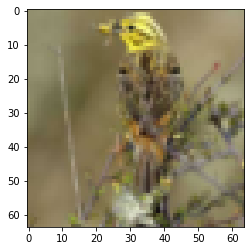

In [4]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(to_pil_image(0.5*x+0.5))

In [5]:
import torch

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

In [6]:
for x,y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])


## Defining Generator

In [7]:
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        nz = params["nz"]
        ngf = params["ngf"]
        noc = params["noc"]
        self.dconv1 = nn.ConvTranspose2d( nz, ngf * 8, kernel_size=4,
                                         stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.dconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.dconv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.dconv4 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d( ngf, noc, kernel_size=4, 
                                         stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))            
        x = F.relu(self.bn3(self.dconv3(x)))        
        x = F.relu(self.bn4(self.dconv4(x)))    
        out = torch.tanh(self.dconv5(x))
        return out

In [10]:
params_gen = {
        "nz": 100,
        "ngf": 64,
        "noc": 3,
        }
model_gen = Generator(params_gen)
device = torch.device("cuda:0")
model_gen.to(device)
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [11]:
with torch.no_grad():
    y= model_gen(torch.zeros(1,100,1,1, device=device))
print(y.shape)    

torch.Size([1, 3, 64, 64])


## Defining Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        nic= params["nic"]
        ndf = params["ndf"]
        self.conv1 = nn.Conv2d(nic, ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)            
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace = True)        
        
        out = torch.sigmoid(self.conv5(x))
        return out.view(-1)

In [13]:
params_dis = {
    "nic": 3,
    "ndf": 64}
model_dis = Discriminator(params_dis)
model_dis.to(device)
print(model_dis)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [14]:
with torch.no_grad():
    y= model_dis(torch.zeros(1,3,h,w, device=device))
print(y.shape)    

torch.Size([1])


In [15]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [16]:
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

## Defining Loss, Optimizer

In [17]:
loss_func = nn.BCELoss()

In [18]:
from torch import optim

lr = 2e-4 
beta1 = 0.5
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [20]:
real_label = 1
fake_label = 0
nz = params_gen["nz"]
num_epochs = 100


loss_history={"gen": [],
              "dis": []}

batch_count = 0
for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)
        model_dis.zero_grad()
        xb = xb.to(device)
        yb = torch.full((ba_si,), real_label, device=device)
        out_dis = model_dis(xb)
        loss_r = loss_func(out_dis, yb)
        loss_r.backward()

        noise = torch.randn(ba_si, nz, 1, 1, device=device)
        out_gen = model_gen(noise)
        out_dis = model_dis(out_gen.detach())
        yb.fill_(fake_label)    
        loss_f = loss_func(out_dis, yb)
        loss_f.backward()
        loss_dis = loss_r + loss_f  
        opt_dis.step()   

        model_gen.zero_grad()
        yb.fill_(real_label)  
        out_dis = model_dis(out_gen)
        loss_gen = loss_func(out_dis, yb)
        loss_gen.backward()
        opt_gen.step()

        loss_history["gen"].append(loss_gen.item())
        loss_history["dis"].append(loss_dis.item())
        batch_count += 1
        if batch_count % 100 == 0:
            print(epoch, loss_gen.item(),loss_dis.item())
        

0 6.517606258392334 1.599970817565918
1 11.220836639404297 0.7304145097732544
1 5.623650550842285 0.26182353496551514
2 4.840178489685059 0.31543225049972534
3 3.5525310039520264 0.5979297161102295
3 8.307265281677246 0.3723141849040985
4 3.248408317565918 0.8758429884910583
5 5.5068864822387695 1.0002334117889404
5 4.287069797515869 1.2395179271697998
6 3.6669321060180664 0.3417946696281433
7 6.921935081481934 0.8474969863891602
7 4.664453506469727 0.2625187337398529
8 4.440066337585449 0.18851032853126526
8 4.15244197845459 0.49994051456451416
9 6.505349159240723 0.843221127986908
10 3.486048460006714 0.4202384352684021
10 2.4183664321899414 1.0132044553756714
11 2.9913058280944824 0.5564441084861755
12 3.883913516998291 1.0065027475357056
12 3.7829442024230957 0.08394086360931396
13 5.292795181274414 0.4178280234336853
14 5.564043045043945 0.2376215159893036
14 1.2615840435028076 0.37470167875289917
15 5.288228988647461 0.6851024627685547
15 4.170971870422363 0.2206004410982132
16 3

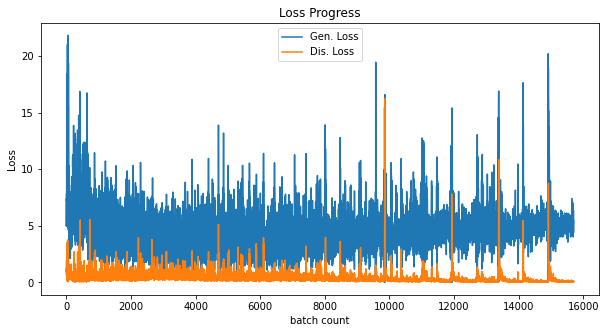

In [21]:
plt.figure(figsize=(10,5))
plt.title("Loss Progress")
plt.plot(loss_history["gen"],label="Gen. Loss")
plt.plot(loss_history["dis"],label="Dis. Loss")
plt.xlabel("batch count")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# store models
import os
path2models = os.environ.get("DATA_DIR")
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, "weights_gen_128.pt")
path2weights_dis = os.path.join(path2models, "weights_dis_128.pt")

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

## Deploying Generator

In [23]:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)
model_gen.eval()

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

torch.Size([16, 100, 1, 1])
torch.Size([16, 3, 64, 64])


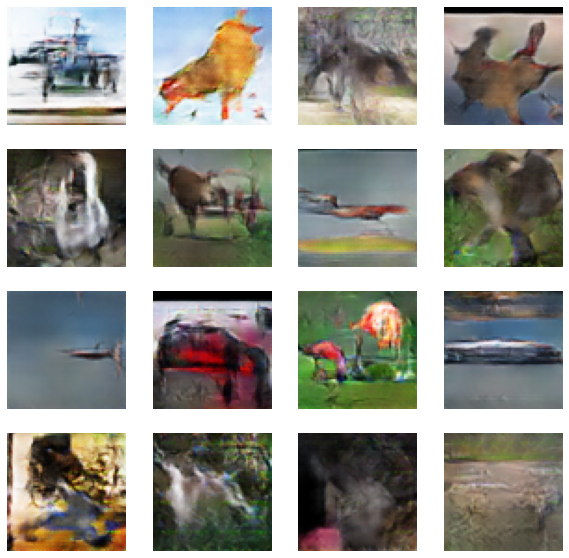

In [24]:
import numpy as np

with torch.no_grad():
    fixed_noise = torch.randn(16, nz, 1, 1, device=device)
    print(fixed_noise.shape)
    img_fake = model_gen(fixed_noise).detach().cpu()    
print(img_fake.shape)

plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5))
    plt.axis("off")
    